<a href="https://colab.research.google.com/github/buzaev-fedor/project-from-ml-course/blob/master/Project_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [84]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download dataset from Kaggle

In [53]:
# df = pd.read_csv("/kaggle/input/dataisbeautiful/r_dataisbeautiful_posts.csv")
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/r_dataisbeautiful_posts.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5,7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
# look dataframe
df.head()

,id,title,score,author,author_flair_text,removed_by,total_awards_received,awarders,created_utc,full_link,num_comments,over_18
0,hbyv2e,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,NaN,NaN,0.0,[],1592565317,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
1,hbynoy,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,NaN,NaN,0.0,[],1592564316,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
2,hbym2y,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,NaN,NaN,0.0,[],1592564089,https://www.reddit.com/r/dataisbeautiful/comme...,1,False
3,hbyirw,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,NaN,moderator,0.0,[],1592563628,https://www.reddit.com/r/dataisbeautiful/comme...,0,False
4,hby1fy,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,Viz Researcher,NaN,0.0,[],1592561119,https://www.reddit.com/r/dataisbeautiful/comme...,2,False


# Preprocessing

### Look null values in dataframe

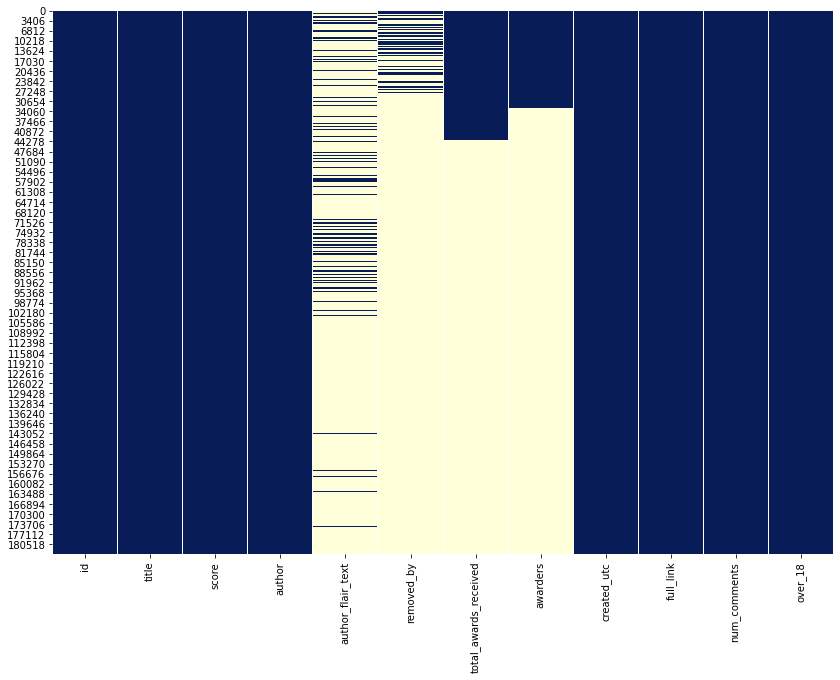

In [55]:
fig, ax = plt.subplots(figsize=(14,10))
sns.heatmap(df.isnull(), cbar=False, cmap="YlGnBu_r")
plt.show()

### Delete unnecessary columns

In [56]:
del df["author_flair_text"]
del df["removed_by"]
del df["total_awards_received"]
del df["awarders"]
del df["created_utc"]
del df["full_link"]
del df["id"]

In [57]:
df.head()

,title,score,author,num_comments,over_18
0,[OC] How Bar Chart Race Animation Can be Creat...,1,Tom10AE,0,False
1,[UK] Labour and Conservative vote share by age...,1,Ge0rgeBr0ughton,1,False
2,[NOC] Number of wallets returned across the wo...,1,i_am_shattered,1,False
3,Largest Banana Producing Countries (1961-2020)...,1,Bilal078692,0,False
4,[OC] Popular Combinations for the StamiStudios...,1,shahinrostami,2,False


In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183891 entries, 0 to 183890
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   title         183890 non-null  object
 1   score         183891 non-null  int64 
 2   author        183891 non-null  object
 3   num_comments  183891 non-null  int64 
 4   over_18       183891 non-null  bool  
dtypes: bool(1), int64(2), object(2)
memory usage: 5.8+ MB


In [59]:
df.title.fillna(" ",inplace = True)

False    182948
True        943
Name: over_18, dtype: int64
0.01


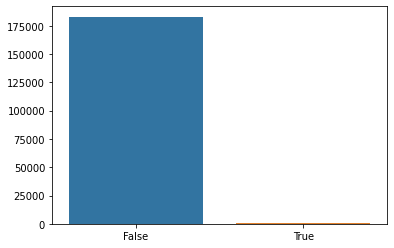

In [60]:
print(df["over_18"].value_counts())
sns.barplot(df["over_18"].value_counts().index, df["over_18"].value_counts().values)
print(round(df["over_18"][df["over_18"] == True].shape[0]/len(df), 2))

Data isn't balanced.

### Lower the text

In [61]:
import string
# realization preprocessing
def preprocess(doc):
    # lower the text
    doc = doc.lower()
    # remove punctuation, spaces, etc.
    for p in string.punctuation + string.whitespace:
        doc = doc.replace(p, ' ')
    # remove extra spaces, merge back
    doc = doc.strip()
    doc = ' '.join([w for w in doc.split(' ') if w != ''])
    return doc

#### Check DataFrame

In [62]:
for colname in df.select_dtypes(include= np.object).columns:
    df[colname] = df[colname].map(preprocess)
df.head()

,title,score,author,num_comments,over_18
0,oc how bar chart race animation can be created...,1,tom10ae,0,False
1,uk labour and conservative vote share by age g...,1,ge0rgebr0ughton,1,False
2,noc number of wallets returned across the world,1,i am shattered,1,False
3,largest banana producing countries 1961 2020 oc,1,bilal078692,0,False
4,oc popular combinations for the stamistudios e...,1,shahinrostami,2,False


In [63]:
df['over_18'] = df['over_18'].map({True: 1, False: 0}).values

In [64]:
df.head()

,title,score,author,num_comments,over_18
0,oc how bar chart race animation can be created...,1,tom10ae,0,0
1,uk labour and conservative vote share by age g...,1,ge0rgebr0ughton,1,0
2,noc number of wallets returned across the world,1,i am shattered,1,0
3,largest banana producing countries 1961 2020 oc,1,bilal078692,0,0
4,oc popular combinations for the stamistudios e...,1,shahinrostami,2,0


In [65]:
lenTrue = int(1/3*df.over_18.value_counts().values[0])
lenTrue

60982

In [66]:
df.over_18.value_counts()

0    182948
1       943
Name: over_18, dtype: int64

### Sample new values

In [67]:
df2 = df[df['over_18'] == 1].sample(n = 60982, replace=True)

In [68]:
df = df.append(df2, ignore_index=True)

In [69]:
df.head()

,title,score,author,num_comments,over_18
0,oc how bar chart race animation can be created...,1,tom10ae,0,0
1,uk labour and conservative vote share by age g...,1,ge0rgebr0ughton,1,0
2,noc number of wallets returned across the world,1,i am shattered,1,0
3,largest banana producing countries 1961 2020 oc,1,bilal078692,0,0
4,oc popular combinations for the stamistudios e...,1,shahinrostami,2,0


In [70]:
df.over_18.value_counts()

0    182948
1     61925
Name: over_18, dtype: int64

In [71]:
df = df.sample(frac=1).reset_index(drop=True)

In [72]:
df.head()

,title,score,author,num_comments,over_18
0,i overlayed 90 of my classmates faces together...,22,mysteroo,9,0
1,oc my tinder data how many and which way i swi...,0,espenbirch,13,1
2,james charles losing subscribers,1,shortyjuice,1,0
3,marvel vs dc most money grossing movies 💵,1,32pratik32,0,0
4,a brief look at possible effects of right to w...,11,bryanmaloney,7,0


In [73]:
y = df['over_18'].map({True: 1, False: 0}).values
y

array([0, 1, 0, ..., 0, 0, 0])

In [74]:
df.drop(['over_18'], axis = 1, inplace=True)
df.head()

,title,score,author,num_comments
0,i overlayed 90 of my classmates faces together...,22,mysteroo,9
1,oc my tinder data how many and which way i swi...,0,espenbirch,13
2,james charles losing subscribers,1,shortyjuice,1
3,marvel vs dc most money grossing movies 💵,1,32pratik32,0
4,a brief look at possible effects of right to w...,11,bryanmaloney,7


### Train-test split

In [75]:
X = df

In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify = y)

In [77]:
X_train.shape, X_test.shape

((195898, 4), (48975, 4))

In [78]:
y_train.shape, y_test.shape

((195898,), (48975,))

In [79]:
X_train

,title,score,author,num_comments
119703,the most searched terms on pornhub by state,5,scratchbomb,4
115447,dầu gội bằng vỏ bưởi,1,kienkhe123,1
216046,oc covid 19 total and daily deaths january 24 ...,1,nibatcat,3
118341,mapfight a system that visually compares two b...,2,kubrickismycopilot,0
57064,comparing ozone concentrations in manhattan an...,13,anguimorpha,10
...,...,...,...,...
195181,oc impact of covid 19 on number of daily unite...,1,tiek00n,1
49479,funny photo series shows chaotic life of a sta...,19,juliajon,0
239806,how to make a hit broadway show,14,jstuartmill,3
241247,pagi asia prajawangsa city hunian menawarkan y...,1,pagi asia,0


## TF-IDF

In [80]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = ENGLISH_STOP_WORDS, ngram_range=(1, 2)).fit(df['title'])

X_train_vectors = vectorizer.transform(X_train['title'])
X_test_vectors = vectorizer.transform(X_test['title'])

In [81]:
X_train_vectors.shape, X_test_vectors.shape

((195898, 647490), (48975, 647490))

In [82]:
num = 65
X_train_vectors[num].data

array([0.06793226, 0.39724121, 0.18410288, 0.36381559, 0.24111066,
       0.39724121, 0.31800925, 0.21966795, 0.16695887, 0.42014438,
       0.31876888])

#### Check TF-IDF

In [83]:
vectorizer.inverse_transform(X_train_vectors[num])[0][np.argsort(X_train_vectors[num].data)]

array(['oc', '2016', 'history', '2016 oc', 'german', 'bundesliga', '1963',
       'german bundesliga', 'history german', 'bundesliga 1963',
       '1963 2016'], dtype='<U105')

### kNN

In [86]:
knn = KNeighborsClassifier().fit(X_train_vectors, y_train)

In [87]:
predicts = knn.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     36590
           1       0.97      1.00      0.98     12385

    accuracy                           0.99     48975
   macro avg       0.98      0.99      0.99     48975
weighted avg       0.99      0.99      0.99     48975



### Multinomial Naive Bayes

In [88]:
clf = MultinomialNB().fit(X_train_vectors, y_train)

In [89]:
predicts = clf.predict((X_test_vectors))
print(classification_report(y_test, predicts))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     36590
           1       0.97      0.98      0.98     12385

    accuracy                           0.99     48975
   macro avg       0.98      0.99      0.99     48975
weighted avg       0.99      0.99      0.99     48975

